This workbook contains codes for predicting share price using LSTM model and develops model for algorithm trading based on MACD and simple moving average.

In [1]:
#Importing libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd

import seaborn as sns

# from datetime import date
import datetime

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')


# getting the data

In [508]:
#getting today's date
today = datetime.datetime.today().strftime('%Y-%m-%d')
print(today)

2021-05-01


In [509]:
#getting last 5years worth of data
startdate = datetime.datetime.today() - datetime.timedelta(days=(365*5))
startdate = startdate.strftime('%Y-%m-%d')
# startdate = today.replace(year=today.year-3)
print(startdate)
#for filtering data (based on 5 days)
startdate_filter = datetime.datetime.today() - datetime.timedelta(days=5)
startdate_filter = startdate_filter.strftime('%Y-%m-%d')
startdate_filter
print(startdate_filter)
# date for tomorrow
tomorrow = datetime.datetime.today() + datetime.timedelta(days=1)
tomorrow = tomorrow.strftime('%Y-%m-%d')
print(tomorrow)

2016-05-02
2021-04-26
2021-05-02


In [510]:
# name of the stock
stock = 'AAPL'
stock1 = 'TUSK'

In [511]:
# get the stock quote
df = web.DataReader(stock1, data_source='yahoo', start=startdate, 
                   end=today)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-10-14,14.29,12.6300,13.66,13.26,5896600.0,12.968104
2016-10-17,14.09,13.0600,13.20,13.87,882300.0,13.564677
2016-10-18,14.04,13.7500,13.89,13.93,387500.0,13.623357
2016-10-19,14.46,13.9000,14.17,14.37,519500.0,14.053671
2016-10-20,14.50,14.1900,14.36,14.33,325400.0,14.014551
...,...,...,...,...,...,...
2021-04-26,4.40,4.1700,4.18,4.29,128300.0,4.290000
2021-04-27,4.50,4.1700,4.29,4.24,65100.0,4.240000
2021-04-28,4.34,3.7300,4.24,3.79,530500.0,3.790000


In [512]:
# percentage change in price
df['change_in_price'] = ((df['Adj Close']-df['Adj Close'].shift(1))/((df['Adj Close']+df['Adj Close'].shift(1))/2))*100
# percentage change in demand
df['change_in_quant'] = ((df['Volume']-df['Volume'].shift(1))/((df['Volume']+df['Volume'].shift(1))/2))*100
# Price Elasticity of Demand (PED)
df['PED'] = abs(df['change_in_quant']/df['change_in_price'])

In [513]:
# excluding the first date as there will be missing data
df = df.iloc[1: , :]
df.head()

,High,Low,Open,Close,Volume,Adj Close,change_in_price,change_in_quant,PED
Date,,,,,,,,,
2016-10-17,14.09,13.06,13.20,13.87,882300.0,13.564677,4.496874,-147.938456,32.898066
2016-10-18,14.04,13.75,13.89,13.93,387500.0,13.623357,0.431657,-77.933533,180.544878
2016-10-19,14.46,13.90,14.17,14.37,519500.0,14.053671,3.109540,29.106946,9.360532
2016-10-20,14.50,14.19,14.36,14.33,325400.0,14.014551,-0.278747,-45.946266,164.831187
2016-10-21,15.00,14.01,14.20,14.39,485600.0,14.073230,0.417823,39.506782,94.553834


In [514]:
#to check if there is any infinity value
# this should be perfectly inelastic
#Replacing the value to perfectly inelastic
df.loc[df['PED']==np.inf, 'PED'] = 0

/opt/anaconda3/envs/maskrcnn/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [515]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
High,1142.0,14.384500,11.345518,0.624000,2.315000,15.315000,21.646250,4.230000e+01
Low,1142.0,13.581396,10.815066,0.560000,2.082500,14.479000,20.469999,4.064000e+01
Open,1142.0,13.984222,11.068950,0.604000,2.230000,14.970000,21.125000,4.134000e+01
Close,1142.0,13.959936,11.064353,0.580000,2.225000,14.930000,21.137500,4.088000e+01
Volume,1142.0,267033.358144,391636.450609,17900.000000,101700.000000,189000.000000,333550.000000,8.991100e+06
Adj Close,1142.0,13.712282,10.820079,0.580000,2.225000,14.630876,20.735766,3.998010e+01
change_in_price,1142.0,-0.108797,6.004753,-43.734011,-2.792352,-0.110233,2.270038,5.635359e+01
change_in_quant,1142.0,-0.854967,55.310090,-159.881522,-36.624879,-4.005732,31.423179,1.934233e+02
PED,1142.0,42.047350,112.054129,0.000000,4.685984,12.914049,35.535349,1.576192e+03


In [517]:
#using relevant data only
features = ['Adj Close','Volume','change_in_price','change_in_quant','PED']
data = df[features]

# EDA and Visualisation

<AxesSubplot:>

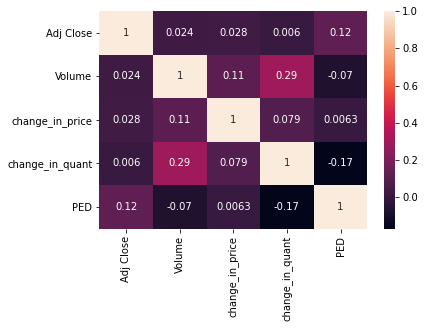

In [519]:
sns.heatmap(data.corr(), annot=True)

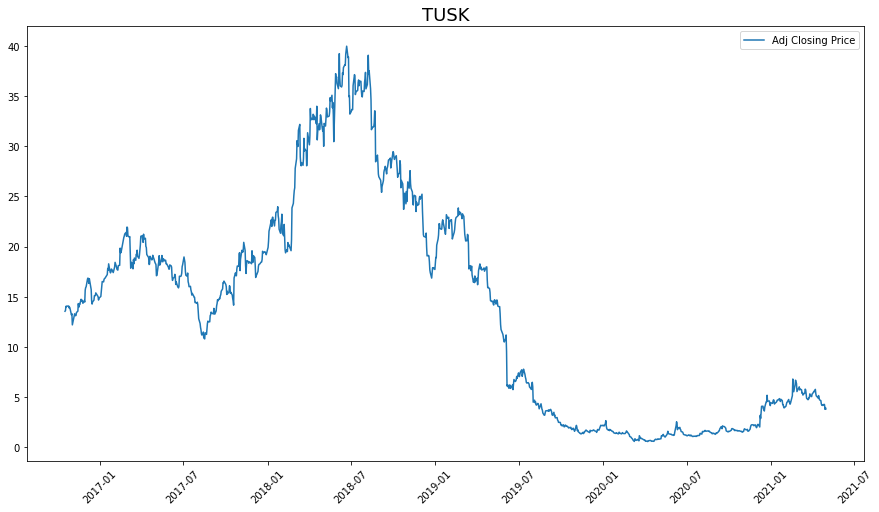

In [520]:
plt.figure(figsize=(15,8))
plt.plot(data['Adj Close'], label='Adj Closing Price')
plt.xticks(rotation=45)
plt.title('TUSK', size=18)
plt.legend()

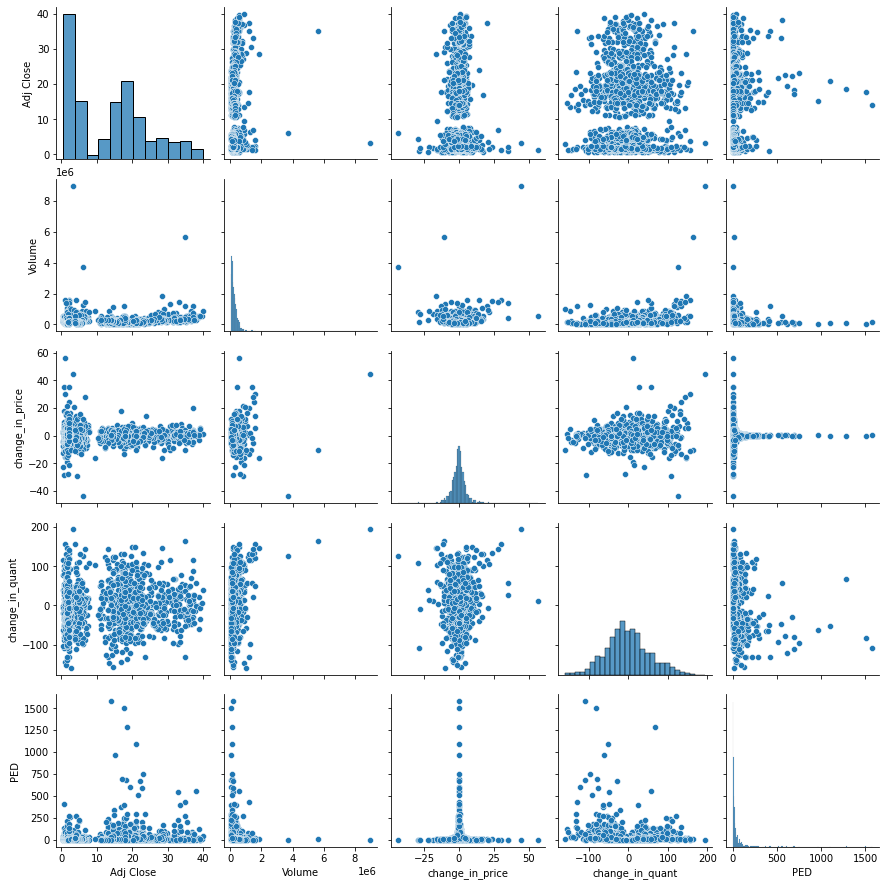

In [521]:
sns.pairplot(data)

# Modelling
### ANN LSTM (30 days, 60 days, 180 days)
### Random Forest Regression
### other regressions


In [522]:
data.describe()

,Adj Close,Volume,change_in_price,change_in_quant,PED
count,1142.000000,1.142000e+03,1142.000000,1142.000000,1142.000000
mean,13.712282,2.670334e+05,-0.108797,-0.854967,42.047350
std,10.820079,3.916365e+05,6.004753,55.310090,112.054129
min,0.580000,1.790000e+04,-43.734011,-159.881522,0.000000
25%,2.225000,1.017000e+05,-2.792352,-36.624879,4.685984
50%,14.630876,1.890000e+05,-0.110233,-4.005732,12.914049
75%,20.735766,3.335500e+05,2.270038,31.423179,35.535349
max,39.980103,8.991100e+06,56.353592,193.423327,1576.192003


In [523]:
data.shape

(1142, 5)

# LSTM

In [524]:
#Import lib
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [525]:
#Convert the dataframe to numpy array
data_LSTM = data.values

In [526]:
data_LSTM.shape

(1142, 5)

### Feature Scaling

In [527]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data_LSTM = scaler.fit_transform(data_LSTM)
print(scaled_data_LSTM.shape)

(1142, 5)


In [528]:
#i'm scaling here for one column so that I can inverse transform the prediction value
# this is the Adj Close
data_LSTM_1 = data_LSTM[:,0]
data_LSTM_1 = np.reshape(data_LSTM_1, (data_LSTM_1.shape[0], 1))
print(data_LSTM_1.shape)
#This scaler is only used for inverse transform prediction value
scaler1 = MinMaxScaler(feature_range=(0,1))
scaler1.fit(data_LSTM_1)

(1142, 1)


MinMaxScaler()

### Creating Training dataset

In [529]:
#creating training dataset
# based on different number of days
def training_LSTM(days, data):
    x_train = []
    y_train = []
    
    for i in range(days, len(data)): 
        x_train.append(data[i-days:i, :])
        y_train.append(data[i, 0])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    y_train = np.reshape(y_train, (y_train.shape[0],1))
    
    print("x_train " + str(days) + str(x_train.shape))
    print("y_train " + str(days) + str(y_train.shape))
    
    return x_train, y_train


In [530]:
#training dataset for 30days
x_train_LSTM_30, y_train_LSTM_30 = training_LSTM(30, scaled_data_LSTM)
#training dataset for 60days
x_train_LSTM_60, y_train_LSTM_60 = training_LSTM(60, scaled_data_LSTM)
#training dataset for 180days
x_train_LSTM_180, y_train_LSTM_180 = training_LSTM(180, scaled_data_LSTM)


x_train 30(1112, 30, 5)
y_train 30(1112, 1)
x_train 60(1082, 60, 5)
y_train 60(1082, 1)
x_train 180(962, 180, 5)
y_train 180(962, 1)


In [531]:
scaled_data_LSTM.shape

(1142, 5)

In [532]:
y_train_LSTM_30.shape

(1112, 1)

# Creating a test dataset

In [533]:
# we are going to keep 80% training and 20% test
training_data_len = math.ceil(len(data_LSTM)*0.8)
training_data_len

914

In [534]:
#creating a test set
def test_LSTM(days, scaled_data_LSTM, data_LSTM): 
    test_data = scaled_data_LSTM[training_data_len - days:, :]
    #Create the data sets x_test and y_test
    x_test = []
    y_test = data_LSTM[training_data_len:, 0]
    for i in range(days, len(test_data)):
        x_test.append(test_data[i-days:i, :])
    x_test = np.array(x_test)
    y_test = np.reshape(y_test, (y_test.shape[0], 1))
    print(x_test.shape, y_test.shape)
    return x_test, y_test

In [535]:
# 30 days
x_test_LSTM_30, y_test_LSTM_30 = test_LSTM(30, scaled_data_LSTM, data_LSTM)
# 60 days
x_test_LSTM_60, y_test_LSTM_60 = test_LSTM(60, scaled_data_LSTM, data_LSTM)
# 180 days
x_test_LSTM_180, y_test_LSTM_180 = test_LSTM(180, scaled_data_LSTM, data_LSTM)

(228, 30, 5) (228, 1)
(228, 60, 5) (228, 1)
(228, 180, 5) (228, 1)


# Building LSTM model

In [536]:
# Building a model
def model_LSTM(x_train):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    #Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    
    return model

In [537]:
# LSTM models
# LSTM 30days
model_LSTM_30 = model_LSTM(x_train_LSTM_30)
# LSTM 60days
model_LSTM_60 = model_LSTM(x_train_LSTM_60)
# LSTM 180days
model_LSTM_180 = model_LSTM(x_train_LSTM_180)

In [541]:
#fit the model
# LSTM 30days
model_LSTM_30.fit(x_train_LSTM_30, y_train_LSTM_30, batch_size=1, epochs=10)


Epoch 1/10
1112/1112 [==============================] - 24s 17ms/step - loss: 0.0083 - accuracy: 0.0015
Epoch 2/10
1112/1112 [==============================] - 20s 18ms/step - loss: 0.0016 - accuracy: 0.0071
Epoch 3/10
1112/1112 [==============================] - 17s 16ms/step - loss: 0.0011 - accuracy: 0.0015
Epoch 4/10
1112/1112 [==============================] - 17s 16ms/step - loss: 9.5331e-04 - accuracy: 0.0013
Epoch 5/10
1112/1112 [==============================] - 17s 16ms/step - loss: 7.7733e-04 - accuracy: 0.0026
Epoch 6/10
1112/1112 [==============================] - 17s 16ms/step - loss: 7.8201e-04 - accuracy: 9.5122e-04
Epoch 7/10
1112/1112 [==============================] - 17s 16ms/step - loss: 7.4449e-04 - accuracy: 2.3214e-04
Epoch 8/10
1112/1112 [==============================] - 17s 16ms/step - loss: 5.1659e-04 - accuracy: 2.4016e-04
Epoch 9/10
1112/1112 [==============================] - 18s 16ms/step - loss: 4.9186e-04 - accuracy: 0.0014
Epoch 10/10
1112/1112 [=====

In [542]:
# LSTM 60days
model_LSTM_60.fit(x_train_LSTM_60, y_train_LSTM_60, batch_size=1, epochs=10)


Epoch 1/10
1082/1082 [==============================] - 34s 29ms/step - loss: 0.0116 - accuracy: 0.0031
Epoch 2/10
1082/1082 [==============================] - 31s 28ms/step - loss: 0.0014 - accuracy: 6.7641e-04
Epoch 3/10
1082/1082 [==============================] - 32s 30ms/step - loss: 0.0011 - accuracy: 0.0022
Epoch 4/10
1082/1082 [==============================] - 31s 29ms/step - loss: 8.7159e-04 - accuracy: 0.0046
Epoch 5/10
1082/1082 [==============================] - 31s 29ms/step - loss: 8.0018e-04 - accuracy: 0.0011
Epoch 6/10
1082/1082 [==============================] - 31s 29ms/step - loss: 7.5862e-04 - accuracy: 7.1483e-04
Epoch 7/10
1082/1082 [==============================] - 31s 29ms/step - loss: 7.6278e-04 - accuracy: 0.0012
Epoch 8/10
1082/1082 [==============================] - 31s 29ms/step - loss: 6.2876e-04 - accuracy: 0.0025
Epoch 9/10
1082/1082 [==============================] - 31s 29ms/step - loss: 6.2763e-04 - accuracy: 0.0026
Epoch 10/10
1082/1082 [=========

In [543]:
# LSTM 180days
model_LSTM_180.fit(x_train_LSTM_180, y_train_LSTM_180, batch_size=1, epochs=10)

Epoch 1/10
962/962 [==============================] - 78s 78ms/step - loss: 0.0155 - accuracy: 0.0014
Epoch 2/10
962/962 [==============================] - 73s 76ms/step - loss: 0.0016 - accuracy: 0.0011
Epoch 3/10
962/962 [==============================] - 73s 76ms/step - loss: 0.0015 - accuracy: 0.0034
Epoch 4/10
962/962 [==============================] - 74s 77ms/step - loss: 0.0012 - accuracy: 0.0035
Epoch 5/10
962/962 [==============================] - 74s 77ms/step - loss: 8.5014e-04 - accuracy: 9.4650e-04
Epoch 6/10
962/962 [==============================] - 73s 76ms/step - loss: 7.2194e-04 - accuracy: 0.0024
Epoch 7/10
962/962 [==============================] - 73s 76ms/step - loss: 8.9198e-04 - accuracy: 0.0020
Epoch 8/10
962/962 [==============================] - 74s 77ms/step - loss: 7.9672e-04 - accuracy: 6.4493e-04
Epoch 9/10
962/962 [==============================] - 76s 79ms/step - loss: 9.7595e-04 - accuracy: 0.0044
Epoch 10/10
962/962 [==============================] -

In [544]:
# predicted price values
def pred_LSTM(model, x_test):
    pred = model.predict(x_test)
    pred = scaler1.inverse_transform(pred)
    return pred

In [545]:
# predicted price values
# LSTM 30 days
pred_LSTM_30 = pred_LSTM(model_LSTM_30, x_test_LSTM_30)
# LSTM 60 days
pred_LSTM_60 = pred_LSTM(model_LSTM_60, x_test_LSTM_60)
# LSTM 180 days
pred_LSTM_180 = pred_LSTM(model_LSTM_180, x_test_LSTM_180)


In [546]:
print(pred_LSTM_30[-1])
print(pred_LSTM_60[-1])
print(pred_LSTM_180[-1])

[3.886468]
[3.3283033]
[3.9195883]


In [547]:
print("Today's closing price")
data.iloc[-1,0]

Today's closing price


3.8299999237060547

# evaluate the model

In [549]:
scores_30 = model_LSTM_30.evaluate(x_test_LSTM_30, y_test_LSTM_30, batch_size=10, verbose=0)
print(scores_30)
scores_60 = model_LSTM_60.evaluate(x_test_LSTM_60, y_test_LSTM_60, batch_size=10, verbose=0)
print(scores_60)
scores_180 = model_LSTM_180.evaluate(x_test_LSTM_180, y_test_LSTM_180, batch_size=10, verbose=0)
print(scores_180)

[11.412304878234863, 0.0]
[11.4926176071167, 0.0]
[11.39013671875, 0.0]


In [550]:
print(model_LSTM_180.metrics_names, scores)

['loss', 'accuracy'] [11.05564022064209, 0.0]


<ipython-input-554-05d77ccbc23c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions_30'] = pred_LSTM_30
<ipython-input-554-05d77ccbc23c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions_60'] = pred_LSTM_60
<ipython-input-554-05d77ccbc23c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

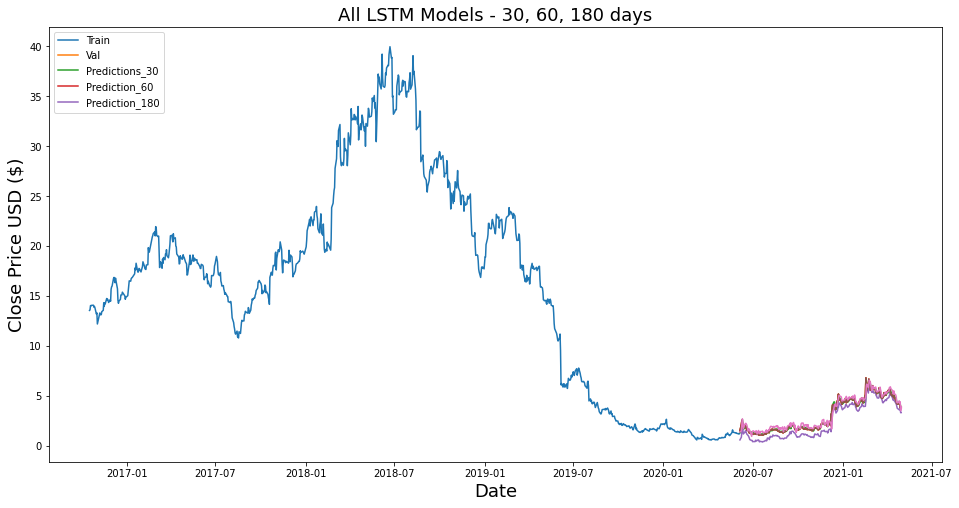

In [554]:
#Plot the data
train = data[: training_data_len]
valid = data[training_data_len:]
valid['Predictions_30'] = pred_LSTM_30
valid['Predictions_60'] = pred_LSTM_60
valid['Predictions_180'] = pred_LSTM_180
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('All LSTM Models - 30, 60, 180 days', size=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close','Predictions_30']])
plt.plot(valid[['Adj Close','Predictions_60']])
plt.plot(valid[['Adj Close','Predictions_180']])

plt.legend(['Train', 'Val', 'Predictions_30','Prediction_60','Prediction_180'], loc='upper left')
plt.show()

<ipython-input-558-5712117f033f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions_30'] = pred_LSTM_30
<ipython-input-558-5712117f033f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions_60'] = pred_LSTM_60
<ipython-input-558-5712117f033f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

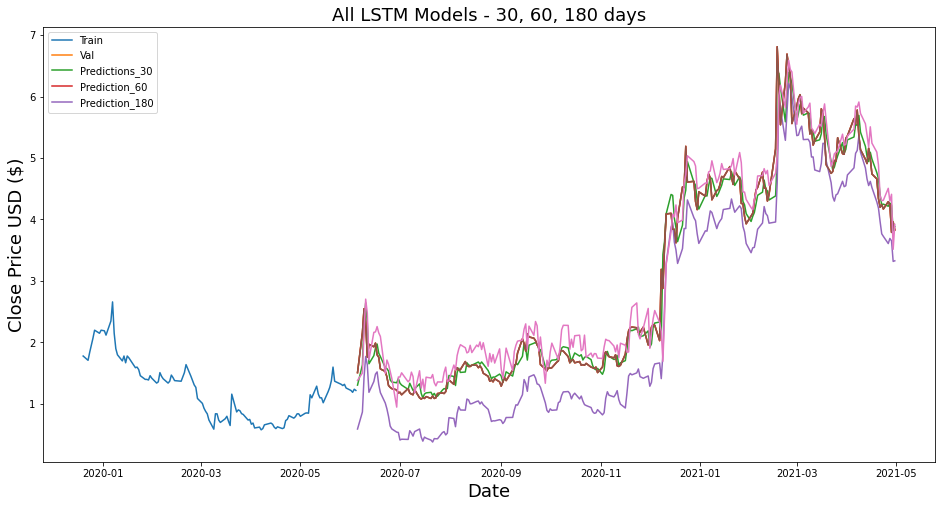

In [558]:
#Plot the data
train = data[800: training_data_len]
valid = data[training_data_len:]
valid['Predictions_30'] = pred_LSTM_30
valid['Predictions_60'] = pred_LSTM_60
valid['Predictions_180'] = pred_LSTM_180
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('All LSTM Models - 30, 60, 180 days', size=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close','Predictions_30']])
plt.plot(valid[['Adj Close','Predictions_60']])
plt.plot(valid[['Adj Close','Predictions_180']])

plt.legend(['Train', 'Val', 'Predictions_30','Prediction_60','Prediction_180'], loc='upper left')
plt.show()

In [559]:
def price_tomorrow(data, features, model, days):
    
    #Create a new dataframe
    new_df = data.filter(features)
    #Get the last 60 day closing price values and convert the dataframe to an array
    last_180_days = new_df[days:].values
    #Scale the data to be values between 0 and 1 
    last_180_days_scaled = scaler.transform(last_180_days)
    #Create an empty list
    X_test = []
    #Append the past 60 days
    X_test.append(last_180_days_scaled)
    #convert the X_test data set to a numpy array
    X_test = np.array(X_test)
    #reshape the data
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
    #Get the predicted scaled price
    pred_price = model.predict(X_test)
    #undo the scaling
    pred_price = scaler1.inverse_transform(pred_price)
    print(pred_price)

In [560]:
print(price_tomorrow(data, features, model_LSTM_30, 30))
print(price_tomorrow(data, features, model_LSTM_60, 60))
print(price_tomorrow(data, features, model_LSTM_180, 180))


[[3.857948]]
None
[[3.2347465]]
None
[[4.0926185]]
None


# storing the predicted stock price for algorithm trading

In [562]:
price_tomorrow = price_tomorrow(data, features, model_LSTM_30, 30)
price_tomorrow

[[3.857948]]


# RandomForest

In [577]:
data.tail()

,Adj Close,Volume,change_in_price,change_in_quant,PED,Prediction
Date,,,,,,
2021-04-26,4.29,128300.0,2.836877,85.428254,30.113488,4.24
2021-04-27,4.24,65100.0,-1.172337,-65.356774,55.749113,3.79
2021-04-28,3.79,530500.0,-11.207966,156.279382,13.943599,3.96
2021-04-29,3.96,228400.0,4.387099,-79.615233,18.147582,3.83
2021-04-30,3.83,91195.0,-3.337615,-85.861794,25.725492,NaN


In [564]:
#Create a new column called Prediction
data['Prediction'] = data[['Adj Close']].shift(-1)
data

<ipython-input-564-960a9a12855d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Prediction'] = data[['Adj Close']].shift(-1)


,Adj Close,Volume,change_in_price,change_in_quant,PED,Prediction
Date,,,,,,
2016-10-17,13.564677,882300.0,4.496874,-147.938456,32.898066,13.623357
2016-10-18,13.623357,387500.0,0.431657,-77.933533,180.544878,14.053671
2016-10-19,14.053671,519500.0,3.109540,29.106946,9.360532,14.014551
2016-10-20,14.014551,325400.0,-0.278747,-45.946266,164.831187,14.073230
2016-10-21,14.073230,485600.0,0.417823,39.506782,94.553834,14.083010
...,...,...,...,...,...,...
2021-04-26,4.290000,128300.0,2.836877,85.428254,30.113488,4.240000
2021-04-27,4.240000,65100.0,-1.172337,-65.356774,55.749113,3.790000
2021-04-28,3.790000,530500.0,-11.207966,156.279382,13.943599,3.960000


In [565]:
#Create the independent dataset (X)
X = np.array(data.drop(['Prediction'], 1))
#remove the last n+1 rows of data where n is the prediction_days
X = X[:len(data) - 1]
print(X)
print(X.shape)

[[ 1.35646772e+01  8.82300000e+05  4.49687398e+00 -1.47938456e+02
   3.28980658e+01]
 [ 1.36233568e+01  3.87500000e+05  4.31657402e-01 -7.79335328e+01
   1.80544878e+02]
 [ 1.40536709e+01  5.19500000e+05  3.10953957e+00  2.91069460e+01
   9.36053243e+00]
 ...
 [ 4.23999977e+00  6.51000000e+04 -1.17233745e+00 -6.53567735e+01
   5.57491134e+01]
 [ 3.78999996e+00  5.30500000e+05 -1.12079657e+01  1.56279382e+02
   1.39435992e+01]
 [ 3.96000004e+00  2.28400000e+05  4.38709874e+00 -7.96152326e+01
   1.81475816e+01]]
(1141, 5)


In [566]:
#Create a dependent data set (y)
y = np.array(data['Prediction'])
# Get all of the y values except the last n+1 rows
y = y[:- 1]
print(y)
print(y.shape)

[13.62335682 14.05367088 14.01455116 ...  3.78999996  3.96000004
  3.82999992]
(1141,)


### Training and test set

In [567]:
#Split the data into 80% training data set and a 20% testing data set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

### feature scaling

In [568]:
# #Scale the data
# scaler = MinMaxScaler(feature_range=(0,1))
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)
# print(x_train.shape)
# # scaler for tranforming the prediction
# scaler1 = MinMaxScaler(feature_range=(0,1))
# scaler1.fit(np.reshape(y_train,(y_train.shape[0], 1)))

In [569]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(912, 5)
(912,)
(229, 5)
(229,)


### Random Forest 

In [570]:
#use the RandomForestRegressor for the model
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators = 4, random_state=1)
forest.fit(x_train, y_train)
print(forest.score(x_test, y_test))

0.994803292475085


In [571]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
accuracy = cross_val_score(forest, x_test, y_test, cv=cv)
accuracy.mean()

0.9921876507036603

In [573]:
#show how close the predicted values and the actual values are
prediction = forest.predict(x_test)
#Print the predicted test values
print(prediction[:5])
print()
print(y_test[:5])

[22.2325139  23.45741177 15.78715181  1.55249998  5.08999991]

[22.63061333 23.16585922 15.45381832  1.55999994  5.46000004]


In [574]:
#Get the validation data for the model 
#Create a variable to store all of the rows in the data set except the last n rows
temp_df = data[:-1]
#Create a variable to store the independent price value 
x_val = temp_df.tail(1)['Adj Close'][0]
#show the data
print(x_val)
# 
x_val = np.array(temp_df.tail(1)[features])
print(x_val)

3.9600000381469727
[[ 3.96000004e+00  2.28400000e+05  4.38709874e+00 -7.96152326e+01
   1.81475816e+01]]


In [576]:
prediction = forest.predict(x_val)
#print the price 
print('The price is predicted to be', prediction)
print('The actual price was', temp_df.tail(1)['Adj Close'][-1])

The price is predicted to be [3.93749994]
The actual price was 3.9600000381469727


# other models

In [578]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR


In [579]:
# Test options and evaluation metric
num_folds = 10
seed = 7
scoring = "r2"

# Spot-Check Algorithms
models = []
models.append((' LR ', LinearRegression()))
models.append((' LASSO ', Lasso()))
models.append((' EN ', ElasticNet()))
models.append((' KNN ', KNeighborsRegressor()))
models.append((' CART ', DecisionTreeRegressor()))
models.append((' SVR ', SVR()))

In [580]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [581]:
# models
def other_model(other_model):
    model = other_model
    model.fit(x_train, y_train)

    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, x_test, y_test, cv=kfold, scoring=scoring)

    model.predict(x_val)
    print(cv_results.mean())
    print(model.predict(x_val))

In [582]:
# Other models
print('Linear Regression', other_model(LinearRegression()))
print('Lasso Regression', other_model(Lasso()))
print('ElasticNet', other_model(ElasticNet()))
print('DecisionTreeRegressor', other_model(DecisionTreeRegressor()))


0.995073344242116
[3.96274187]
Linear Regression None
0.9950730183965174
[4.05896471]
Lasso Regression None
0.9950692511025687
[4.05786621]
ElasticNet None
0.9897345520864136
[3.82999992]
DecisionTreeRegressor None


In [583]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    # print(cv_results)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


 LR : 0.996535 (0.000796)
 LASSO : 0.996485 (0.000813)
 EN : 0.996481 (0.000812)
 KNN : -0.200583 (0.128103)
 CART : 0.992725 (0.001749)
 SVR : -0.096136 (0.068251)


# Algorithmic Trading Strategy 
## MACD
## SMA

# including the tomorrow's price in the data set for algorithm trading strategy

In [585]:
# date for tomorrow
tomorrow = datetime.datetime.today() + datetime.timedelta(days=1)
# tomorrow = tomorrow.strftime('%Y-%m-%d')
print(tomorrow)

2021-05-02 01:03:37.648902


In [586]:
data_trading = df[['Adj Close']].copy()
data_trading

,Adj Close
Date,
2016-10-17,13.564677
2016-10-18,13.623357
2016-10-19,14.053671
2016-10-20,14.014551
2016-10-21,14.073230
...,...
2021-04-26,4.290000
2021-04-27,4.240000
2021-04-28,3.790000


In [587]:
# adding price tomorrow to the data
add_price = pd.DataFrame(price_tomorrow, index=[tomorrow], 
                         columns = ['Adj Close'])
add_price

,Adj Close
2021-05-02 01:03:37.648902,NaN


In [588]:
data_trading = data_trading.append(add_price)
data_trading

,Adj Close
2016-10-17 00:00:00.000000,13.564677
2016-10-18 00:00:00.000000,13.623357
2016-10-19 00:00:00.000000,14.053671
2016-10-20 00:00:00.000000,14.014551
2016-10-21 00:00:00.000000,14.073230
...,...
2021-04-27 00:00:00.000000,4.240000
2021-04-28 00:00:00.000000,3.790000
2021-04-29 00:00:00.000000,3.960000
2021-04-30 00:00:00.000000,3.830000


# MACD

In [589]:
# Calculate the MACD and signal line indicators
#calculate the short term exponential moving average (EMA)
shortEMA = data_trading['Adj Close'].ewm(span=12, adjust=False).mean()
#Calculate the long term EMA
longEMA = data_trading['Adj Close'].ewm(span=26, adjust=False).mean()
#Calculate the MACD line
MACD = shortEMA - longEMA
#calculate the signal line
signal = MACD.ewm(span=9, adjust=False).mean()

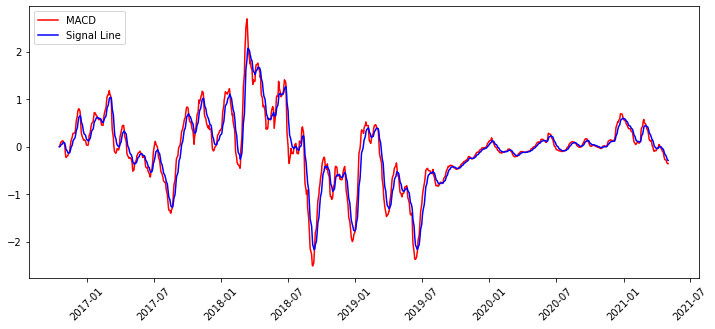

In [590]:
#plot the chart
plt.figure(figsize=(12,5))
plt.plot(data_trading.index, MACD, label = 'MACD', color='red')
plt.plot(data_trading.index, signal, label = 'Signal Line', color='blue')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

In [591]:
#Create new columns for the data
data_trading['MACD'] = MACD
data_trading['Signal Line'] = signal 
#Show the data
data_trading.tail()

,Adj Close,MACD,Signal Line
2021-04-27 00:00:00.000000,4.24,-0.287679,-0.204988
2021-04-28 00:00:00.000000,3.79,-0.326071,-0.229205
2021-04-29 00:00:00.000000,3.96,-0.338872,-0.251138
2021-04-30 00:00:00.000000,3.83,-0.355411,-0.271993
2021-05-02 01:03:37.648902,NaN,-0.355411,-0.288676


In [592]:
#Create a function to signal when to buy and sell an asset
def buy_sell(signal):
    Buy = []
    Sell = []
    flag = -1
    
    for i in range(0, len(signal)): 
        if signal['MACD'][i] > signal['Signal Line'][i]:
            Sell.append(np.nan)
            if flag != 1:
                Buy.append(signal['Adj Close'][i])
                flag = 1
            else:
                Buy.append(np.nan)
        elif signal['MACD'][i] < signal['Signal Line'][i]:
            Buy.append(np.nan)
            if flag != 0:
                Sell.append(signal['Adj Close'][i])
                flag = 0
            else:
                Sell.append(np.nan)                
        else: 
            Buy.append(np.nan)
            Sell.append(np.nan)
    return (Buy, Sell)

In [593]:
#Create buy and sell column 
a = buy_sell(data_trading)
data_trading['Buy_Signal_Price'] = a[0]
data_trading['Sell_Signal_Price'] = a[1]

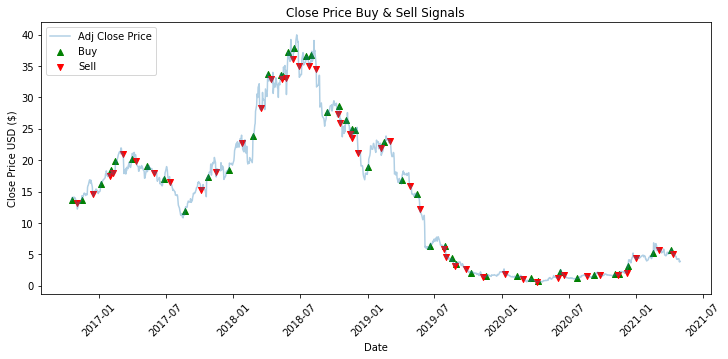

In [594]:
#visually show the stock buy and sell signals
plt.figure(figsize=(12,5))
plt.scatter(data_trading.index, data_trading['Buy_Signal_Price'], color='green', label='Buy', marker='^', alpha=1)
plt.scatter(data_trading.index, data_trading['Sell_Signal_Price'], color='red', label='Sell', marker='v', alpha=1)
plt.plot(data_trading['Adj Close'], label='Adj Close Price', alpha = 0.35)
plt.xticks(rotation=45)
plt.title('Close Price Buy & Sell Signals')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend(loc='upper left')
plt.show()

In [595]:
buy, sell = np.array(a)
if buy[-1] > 0:
    print('BUY')
elif sell[-1] > 0:
    print('SELL')
else:
    print('HOLD')


HOLD


# Simple Moving average

In [596]:
#Create the simple moving average with a 30 day window
SMA30 = pd.DataFrame()
SMA30['Adj Close Price'] = data_trading['Adj Close'].rolling(window=30).mean()
SMA30

,Adj Close Price
2016-10-17 00:00:00.000000,NaN
2016-10-18 00:00:00.000000,NaN
2016-10-19 00:00:00.000000,NaN
2016-10-20 00:00:00.000000,NaN
2016-10-21 00:00:00.000000,NaN
...,...
2021-04-27 00:00:00.000000,4.990167
2021-04-28 00:00:00.000000,4.923167
2021-04-29 00:00:00.000000,4.864500
2021-04-30 00:00:00.000000,4.814500


In [597]:
#Create the simple moving average with a 100 day window
SMA100 = pd.DataFrame()
SMA100['Adj Close Price'] = data_trading['Adj Close'].rolling(window=100).mean()
SMA100

,Adj Close Price
2016-10-17 00:00:00.000000,NaN
2016-10-18 00:00:00.000000,NaN
2016-10-19 00:00:00.000000,NaN
2016-10-20 00:00:00.000000,NaN
2016-10-21 00:00:00.000000,NaN
...,...
2021-04-27 00:00:00.000000,4.7465
2021-04-28 00:00:00.000000,4.7619
2021-04-29 00:00:00.000000,4.7786
2021-04-30 00:00:00.000000,4.7941


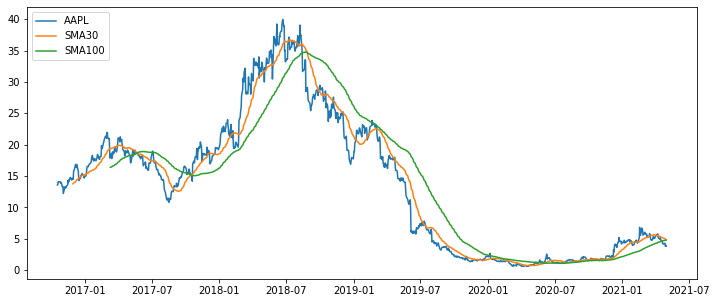

In [598]:
#Visualize the data
plt.figure(figsize=(12,5))
plt.plot(data_trading['Adj Close'], label = 'AAPL')
plt.plot(SMA30['Adj Close Price'], label = 'SMA30')
plt.plot(SMA100['Adj Close Price'], label = 'SMA100')
plt.legend(loc='upper left')
plt.show()

In [599]:
data_trading

,Adj Close,MACD,Signal Line,Buy_Signal_Price,Sell_Signal_Price
2016-10-17 00:00:00.000000,13.564677,0.000000,0.000000,NaN,NaN
2016-10-18 00:00:00.000000,13.623357,0.004681,0.000936,13.623357,NaN
2016-10-19 00:00:00.000000,14.053671,0.042622,0.009273,NaN,NaN
2016-10-20 00:00:00.000000,14.014551,0.068742,0.021167,NaN,NaN
2016-10-21 00:00:00.000000,14.073230,0.093103,0.035554,NaN,NaN
...,...,...,...,...,...
2021-04-27 00:00:00.000000,4.240000,-0.287679,-0.204988,NaN,NaN
2021-04-28 00:00:00.000000,3.790000,-0.326071,-0.229205,NaN,NaN
2021-04-29 00:00:00.000000,3.960000,-0.338872,-0.251138,NaN,NaN
2021-04-30 00:00:00.000000,3.830000,-0.355411,-0.271993,NaN,NaN


In [600]:
# Create a new data frame to store all the data
data_trading['SMA30'] = SMA30['Adj Close Price']
data_trading['SMA100'] = SMA100['Adj Close Price']
data_trading

,Adj Close,MACD,Signal Line,Buy_Signal_Price,Sell_Signal_Price,SMA30,SMA100
2016-10-17 00:00:00.000000,13.564677,0.000000,0.000000,NaN,NaN,NaN,NaN
2016-10-18 00:00:00.000000,13.623357,0.004681,0.000936,13.623357,NaN,NaN,NaN
2016-10-19 00:00:00.000000,14.053671,0.042622,0.009273,NaN,NaN,NaN,NaN
2016-10-20 00:00:00.000000,14.014551,0.068742,0.021167,NaN,NaN,NaN,NaN
2016-10-21 00:00:00.000000,14.073230,0.093103,0.035554,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-04-27 00:00:00.000000,4.240000,-0.287679,-0.204988,NaN,NaN,4.990167,4.7465
2021-04-28 00:00:00.000000,3.790000,-0.326071,-0.229205,NaN,NaN,4.923167,4.7619
2021-04-29 00:00:00.000000,3.960000,-0.338872,-0.251138,NaN,NaN,4.864500,4.7786
2021-04-30 00:00:00.000000,3.830000,-0.355411,-0.271993,NaN,NaN,4.814500,4.7941


In [601]:
#Create a function to signal when to buy and sell the asset/stock
def buy_sell_SMA(data): 
    Buy = []
    Sell = []
    flag = -1

    for i in range(len(data)):
        if data['SMA30'][i] > data['SMA100'][i]:
            if flag !=1:
                Buy.append(data['Adj Close'][i])
                Sell.append(np.nan)
                flag = 1 
            else: 
                Buy.append(np.nan)
                Sell.append(np.nan)
        elif data['SMA30'][i] < data['SMA100'][i]:
            if flag !=0: 
                Buy.append(np.nan)
                Sell.append(data['Adj Close'][i])
                flag = 0
            else: 
                Buy.append(np.nan)
                Sell.append(np.nan)
        else:
            Buy.append(np.nan)
            Sell.append(np.nan)
            
    return (Buy, Sell)

In [602]:
#store the buy and sell data into a variable
buy_sell = buy_sell_SMA(data_trading)
data_trading['Buy_Signal_Price'] = buy_sell[0]
data_trading['Sell_Signal_Price'] = buy_sell[1]
data_trading

,Adj Close,MACD,Signal Line,Buy_Signal_Price,Sell_Signal_Price,SMA30,SMA100
2016-10-17 00:00:00.000000,13.564677,0.000000,0.000000,NaN,NaN,NaN,NaN
2016-10-18 00:00:00.000000,13.623357,0.004681,0.000936,NaN,NaN,NaN,NaN
2016-10-19 00:00:00.000000,14.053671,0.042622,0.009273,NaN,NaN,NaN,NaN
2016-10-20 00:00:00.000000,14.014551,0.068742,0.021167,NaN,NaN,NaN,NaN
2016-10-21 00:00:00.000000,14.073230,0.093103,0.035554,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-04-27 00:00:00.000000,4.240000,-0.287679,-0.204988,NaN,NaN,4.990167,4.7465
2021-04-28 00:00:00.000000,3.790000,-0.326071,-0.229205,NaN,NaN,4.923167,4.7619
2021-04-29 00:00:00.000000,3.960000,-0.338872,-0.251138,NaN,NaN,4.864500,4.7786
2021-04-30 00:00:00.000000,3.830000,-0.355411,-0.271993,NaN,NaN,4.814500,4.7941


Text(0.5, 1.0, '')

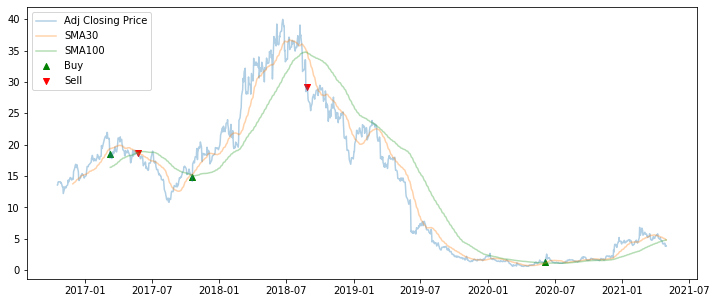

In [603]:
# visualise the data and the strategy to buy and sell the stock
plt.figure(figsize=(12, 5))
plt.plot(data_trading['Adj Close'], label = 'Adj Closing Price', alpha=0.35)
plt.plot(data_trading['SMA30'], label = 'SMA30', alpha=0.35)
plt.plot(data_trading['SMA100'], label = 'SMA100', alpha=0.35)
plt.scatter(data_trading.index, data_trading['Buy_Signal_Price'], label = 'Buy', marker = '^', color = 'green')
plt.scatter(data_trading.index, data_trading['Sell_Signal_Price'], label = 'Sell', marker = 'v', color = 'red')
plt.legend(loc='upper left')
plt.title('')

In [604]:
buy, sell = np.array(buy_sell)
if buy[-1] > 0:
    print('BUY')
elif sell[-1] > 0:
    print('SELL')
else:
    print('HOLD')


HOLD
